In [ ]:
import os
import pandas as pd
import plotly.graph_objs as go
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import pickle as pkl
import importlib
import loading_edp as le
import seaborn as sns
import great_tables as gt
from concurrent.futures import ThreadPoolExecutor
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:


# Base directory (set to a location you have write access to)
base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"

# Directory containing the CSV files
data_directory = os.path.join(base_directory, 'edp_data')

# Directory to save filtered data
filtered_data_directory = os.path.join(base_directory, 'filtered_data_real')

# Directory to save profiles
site_profiles_directory = os.path.join(base_directory, 'full_profiles_real')

profiles_directory = os.path.join(base_directory,'resampled_30min_data_cleaned')

# Ensure these directories exist
for directory in [data_directory, filtered_data_directory, site_profiles_directory,resampled_data_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
# Generate list of preliminary site ids which have ac and consumption data for 2023.

In [226]:


# Load the first dataset (this could be the one with the date range)
df1 = pd.read_csv(os.path.join(base_directory, 'survey/edp_data_first_and_last_dates.csv'))
# Load the second dataset (the one with circuit data)
df2 = pd.read_csv(os.path.join(base_directory, 'edp_data/edp_data_2023_01.csv'))

eligible_sites = le.filter_sites_for_aircon(df1, df2)


KeyboardInterrupt: 

In [7]:

# Manual Drops
# Remove sites with no aircon data or zero aircon load
eligible_sites.remove("W0220")
eligible_sites.remove("W0162")
# Remove site with negative gross consumption
eligible_sites.remove("W0073") # net consumption and gross consumption is almost always negative (inverter issue)
# Remove site with extremely premature ending data
eligible_sites.remove("W0310") # ends in august

# pickle final eligible sites
with open("total_site_ids.pkl", "wb") as f:
    pkl.dump(eligible_sites, f)


In [3]:
# Create combined dataframe of all edp month raw data

# Define directories
data_directory = os.path.join(base_directory, "edp_data")

# Get list of CSV files
filepaths = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.csv')]

def load_file(filepath):
    """Function to load a single file with optimized settings."""
    try:
        print("Reading", filepath)
        return pd.read_csv(filepath, usecols=['edp_site_id', 'datetime', 'circuit_label', 'real_energy'], 
                           dtype={'real_energy': 'float32'},  # Reduced precision
                           engine='c',  # Faster default parser
                           on_bad_lines='skip')
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    dfs = list(executor.map(load_file, filepaths))

# Concatenate all processed DataFrames
if dfs:
    full_data = pd.concat(dfs, ignore_index=True)
    print("Successfully loaded all files into a single DataFrame.")
else:
    print("No valid data to process.")


Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_01.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_02.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_03.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_04.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_05.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_06.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_07.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_08.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_2023_09.csv
Reading C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\edp_data\edp_data_20

In [4]:
# Export full_data df of combined edp month data to parquet file

# table = pa.Table.from_pandas(full_data, preserve_index = True)
# pq.write_table(table, os.path.join(base_directory, 'full_edp_data.parquet'))

In [46]:
# if it doesn't exist, open total_sites_id.pkl as eligible_sites
if not 'eligible_sites' in locals():
    with open("total_site_ids.pkl", "rb") as f:
        eligible_sites = pkl.load(f)


In [47]:

site_profiles_directory = os.path.join(base_directory, 'resampled_30min_data_cleaned')
importlib.reload(le)
big_missing_sites_df = le.process_site(eligible_sites, full_data, site_profiles_directory)


Processing: S0261
Saved processed data for site S0261

Processing: S0291
Saved processed data for site S0291

Processing: W0026
Saved processed data for site W0026

Processing: W0236
Saved processed data for site W0236

Processing: W0198
Saved processed data for site W0198

Processing: W0186
Saved processed data for site W0186

Processing: W0081
Saved processed data for site W0081

Processing: W0013
Saved processed data for site W0013

Processing: S0517
Saved processed data for site S0517

Processing: S0483
Saved processed data for site S0483

Processing: W0044
Saved processed data for site W0044

Processing: W0076
Saved processed data for site W0076

Processing: S0430
Saved processed data for site S0430

Processing: W0352
Saved processed data for site W0352

Processing: S0387
Saved processed data for site S0387

Processing: W0003
Saved processed data for site W0003

Processing: W0121
Saved processed data for site W0121

Processing: W0188
Saved processed data for site W0188

Processin

In [48]:
# printing the sites that have more than 2 weeks of missing data
print(big_missing_sites_df)
big_missing_sites_df.to_csv(os.path.join(base_directory, 'sites_with_more_2weeks_missing.csv'))

   site_id  max_gap_days                           reason
0    W0082    229.298611  Consecutive gap exceeds 2 weeks
1    W0324     35.038194  Consecutive gap exceeds 2 weeks
2    W0335     68.819444  Consecutive gap exceeds 2 weeks
3    W0175     78.260417  Consecutive gap exceeds 2 weeks
4    W0120     33.854167  Consecutive gap exceeds 2 weeks
5    W0243     62.701389  Consecutive gap exceeds 2 weeks
6    S0159     79.993056  Consecutive gap exceeds 2 weeks
7    W0315     88.149306  Consecutive gap exceeds 2 weeks
8    S0024     26.006944  Consecutive gap exceeds 2 weeks
9    S0444     30.638889  Consecutive gap exceeds 2 weeks
10   S0470     57.184028  Consecutive gap exceeds 2 weeks
11   W0330     60.531250  Consecutive gap exceeds 2 weeks
12   S0318     75.416667  Consecutive gap exceeds 2 weeks
13   W0241     20.274306  Consecutive gap exceeds 2 weeks
14   W0224     47.208333  Consecutive gap exceeds 2 weeks


In [49]:
# print number of files in folder resampled_30min_data_cleaned
print(len(os.listdir(site_profiles_directory)))

228


There are 228 sites that have been cleaned and resampled. Now, we look back through for sites that have outlier or negative profiles. 

In [ ]:
## Create final eligible sites (with any sites that have consecutive missing data of more than two weeks removed)

# remove sites 

In [ ]:
# Double check that there are no files with missing data intervals of at least two weeks
importlib.reload(le)
# Example usage
directory_path = 'C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning/resampled_30min_data_cleaned'
missing_files_list = le.list_files_with_missing_intervals(directory_path)
print('Files with missing data intervals of at least two weeks:')
for missing_file in missing_files_list:
    print(missing_file) #should print nothing


Files with missing data intervals of at least two weeks:


In [110]:


importlib.reload(le)
survey = os.path.join(base_directory, 'survey/edp_survey_aircon.csv')
# Run the function
df_daily_consumption, df_daily_ac_consumption, sites_with_low_aircon_consumption, sites_with_negative_aircon_consumption = le.evaluate_daily_averages(profiles_directory, survey)


In [106]:
print(sites_with_negative_aircon_consumption)

['W0061']


In [99]:
print(sites_with_low_aircon_consumption)

['W0061', 'W0166', 'W0297']


In [ ]:
# this helps us visualize some of the outlier or weird profiles with low or negative aircon consumption
#plot
resampled_data_directory = os.path.join(base_directory,'resampled_30min_data_cleaned')

for site_id in sites_with_low_aircon_consumption:
    # Read the CSV file for the current site ID
    filepath = os.path.join(resampled_data_directory, f'{site_id}_profile.csv')
    df = pd.read_csv(filepath)

    # Create trace for PV generation
    if 'pv' in df.columns:
        trace_pv = go.Scatter(x=df['TS'], y=df['pv'], mode='lines', name='PV Generation')
    trace_aircon = go.Scatter(x=df['TS'], y=df['air_conditioning_load'], mode='lines', name='Air Conditioning Load')

    # Create trace for load
    trace_load = go.Scatter(x=df['TS'], y=df['kwh'], mode='lines', name='Load')

    # Define layout
    layout = go.Layout(
        title=f'Air Conditioning, PV (if applicable), and Load Over Time ({site_id})',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Energy (kWh)'),
        legend=dict(x=0.01, y=0.99),
        plot_bgcolor='rgba(0,0,0,0)'
    )

    # Create figure object combining PV generation and load traces
    fig = go.Figure(data=[trace_load, trace_pv, trace_aircon], layout=layout)

    # Display the figure
    fig.show()

When sites_with_negative_aircon_consumption has sites in it, individually run through above function to understand why they are identified: 
Here are some of the manually observed results: 

* S0106 has a negative "aircon" profile which mirrors the pv generation profile exactly
* S0179 has some very little positive aircon usage and some very little negative aircon usage but almost always close to 0
* S0225's meter seems shifted where it's mostly always -0.092, could transform this profile 
* S0495's aircon meter is always zero. 
* S0569's aircon meter is always zero
* W0060's load and aircon usage data seems flipped 
* W0106 has a flipped aircon usage
* W0145's aircon meter is always zero 
* W0258 has a flipped aircon usage
* W0260's aircon meter is always zero
* W0287's aircon meter is *almost* always zero
* W0336 has a flipped aircon usage 
* W0061 needed to be shifted by 0.09


From this, 
the sites that need to be removed for either no aircon meter data or unusual are: "S0106", "S0179", "S0495", "S0569", "W0145", "W0260", "W0287", "S0353", 
the sites that need their "air_conditioning_load" column values flipped: "W0060", "W0258", "W0336", "W0106", "W0297"
the sites that need their "kwh" column values flipped: "W0060" 
the sites that need their air conditioning load transformed and by how much: {"S0025", 0.092} {"W0061", 0.09}

In [68]:


def process_csv_files(folder_path):
    # Sites to exclude (these files will be deleted)
    sites_to_remove = {"S0106", "S0179", "S0495", "S0569", "W0145", "W0260", "W0287", "S0353", "S0568"}
    
    # Sites that need air conditioning load flipped
    flip_aircon = {"W0060", "W0258", "W0336", "W0106", "W0297"}
    
    # Sites that need kwh flipped
    flip_kwh = {"W0060"}
    
    # Sites that need air conditioning load transformed with specific scaling
    transform_aircon = {"S0025": 0.092, "S0225": 0.1, "W0061": 0.08, "W0297": 0.1}
    
    # Process each CSV file in the folder
    folder = os.path.join(base_directory, folder_path)
    for filename in os.listdir(folder):
        file = os.path.join(folder, filename)
        # Extract site_id from filename
        site_id = filename.split("_")[0]
        
        # Delete files for sites that should be removed
        if site_id in sites_to_remove:
            print(f"Deleting {filename}")
            os.remove(file)
            continue
            
        print(f"Processing {filename}")
        
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Flip air conditioning load if needed
        if site_id in flip_aircon:
            print(f"Flipping air_conditioning_load for {site_id}")
            df['air_conditioning_load'] = -df['air_conditioning_load']
            
        # Transform air conditioning load if needed
        if site_id in transform_aircon:
            scaling_factor = transform_aircon[site_id]
            print(f"Transforming air_conditioning_load for {site_id} with scaling factor {scaling_factor}")
            df['air_conditioning_load'] = df['air_conditioning_load'] + scaling_factor
            
        # Flip kwh if needed
        if site_id in flip_kwh:
            print(f"Flipping kwh for {site_id}")
            df['kwh'] = -df['kwh']
            
        # Save the modified file (overwriting the original)
        df.to_csv(file, index=False)
        print(f"Saved changes to {filename}")

# Example usage
process_csv_files(resampled_data_directory)

Processing S0083_profile.csv
Saved changes to S0083_profile.csv
Processing S0089_profile.csv
Saved changes to S0089_profile.csv
Deleting S0106_profile.csv
Processing S0107_profile.csv
Saved changes to S0107_profile.csv
Processing S0110_profile.csv
Saved changes to S0110_profile.csv
Processing S0111_profile.csv
Saved changes to S0111_profile.csv
Processing S0173_profile.csv
Saved changes to S0173_profile.csv
Processing S0177_profile.csv
Saved changes to S0177_profile.csv
Deleting S0179_profile.csv
Processing S0188_profile.csv
Saved changes to S0188_profile.csv
Processing S0199_profile.csv
Saved changes to S0199_profile.csv
Processing S0206_profile.csv
Saved changes to S0206_profile.csv
Processing S0208_profile.csv
Saved changes to S0208_profile.csv
Processing S0209_profile.csv
Saved changes to S0209_profile.csv
Processing S0216_profile.csv
Saved changes to S0216_profile.csv
Processing S0225_profile.csv
Saved changes to S0225_profile.csv
Processing S0227_profile.csv
Saved changes to S022

In [111]:
# once removing, flipping, and transforming has been done, re-run the function to evaluate daily averages

df_daily_consumption, df_daily_ac_consumption, sites_with_low_aircon_consumption, sites_with_negative_aircon_consumption = evaluate_daily_averages(profiles_directory, survey)
print(sites_with_low_aircon_consumption)
print(sites_with_negative_aircon_consumption)

['W0166']
[]


C:\Users\CEEM04\AppData\Local\Temp\ipykernel_12112\734042840.py:10: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



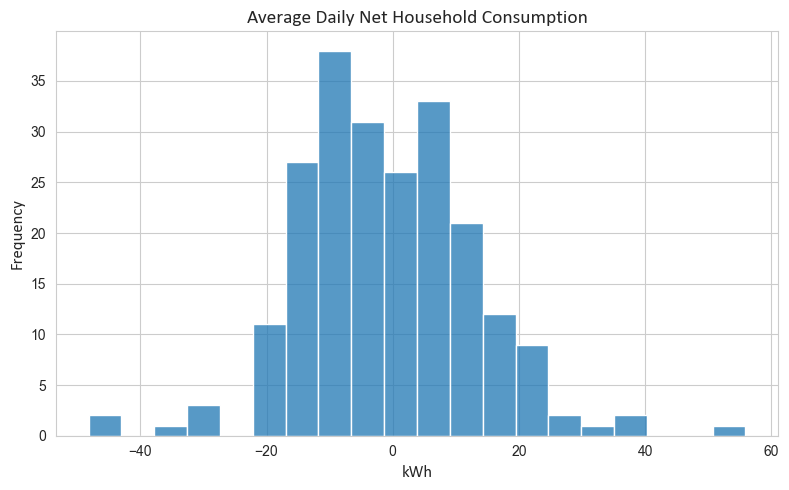

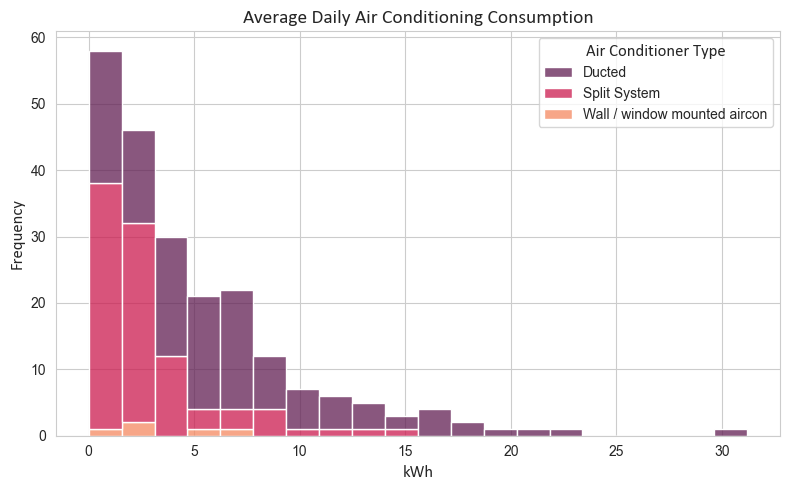

In [125]:

output_directory = os.path.join(base_directory, 'figures_for_paper')
def create_histogram(data, value_column, category_column, title, xaxis_title, output_file, bins=20, width=8, height=5):
    # Set the Seaborn style
    sns.set_style("whitegrid")
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(width, height))
    
    # Create the histogram using Seaborn, colored by category
    sns.histplot(data=data, x=value_column, hue=category_column, bins=bins, kde=False, 
                 palette="rocket", ax=ax, multiple="stack")
    
    # Set fonts to Calibri
    plt.rcParams["font.family"] = "Calibri"
    
    # Set chart title and labels
    ax.set_title(title, fontsize=14, fontname="Calibri")
    ax.set_xlabel(xaxis_title, fontsize=12, fontname="Calibri")
    ax.set_ylabel('Frequency', fontsize=12, fontname="Calibri")
    

    # Get the current legend from Seaborn
    legend = ax.get_legend()

    # If the legend exists, modify its title
    if legend:
        legend.set_title("Air Conditioner Type", prop={"family": "Calibri", "size": 12})

    # Save the figure to the output file
    plt.tight_layout()
    plt.savefig(output_file, format='png')
    
    # Show the plot (optional)
    plt.show()

df_daily_ac_consumption["aircon_type_simplified"] = df_daily_ac_consumption["aircon_type_simplified"].astype("category")

# Create and save each histogram
create_histogram(df_daily_consumption, 'daily_avg_kwh',  None, 
                 'Average Daily Net Household Consumption', 'kWh',
                 os.path.join(output_directory, 'household_consumption_histogram.png'))

create_histogram(df_daily_ac_consumption, 'daily_avg_aircon_kwh', 'aircon_type_simplified', 
                 'Average Daily Air Conditioning Consumption', 'kWh',
                 os.path.join(output_directory, 'average_daily_ac_consumption_histogram.png'))


In [126]:
# to find the new number of files in the folder resampled_30min_data_cleaned
print(len(os.listdir(resampled_data_directory)))

220


In [127]:
# scrape list of files in resampled_30min_data_cleaned
files = os.listdir(resampled_data_directory)
final_eligible_sites = [f.split('_')[0] for f in files if f.endswith('.csv')]
print(final_eligible_sites)

['S0083', 'S0089', 'S0107', 'S0110', 'S0111', 'S0173', 'S0177', 'S0188', 'S0199', 'S0206', 'S0208', 'S0209', 'S0216', 'S0225', 'S0227', 'S0229', 'S0230', 'S0233', 'S0238', 'S0245', 'S0249', 'S0250', 'S0260', 'S0261', 'S0268', 'S0284', 'S0291', 'S0299', 'S0301', 'S0309', 'S0314', 'S0324', 'S0337', 'S0338', 'S0339', 'S0341', 'S0349', 'S0351', 'S0372', 'S0376', 'S0387', 'S0392', 'S0407', 'S0410', 'S0429', 'S0430', 'S0439', 'S0451', 'S0456', 'S0462', 'S0463', 'S0482', 'S0483', 'S0509', 'S0516', 'S0517', 'S0545', 'S0548', 'S0562', 'S0573', 'S0576', 'S0579', 'S0586', 'S0587', 'W0001', 'W0002', 'W0003', 'W0004', 'W0005', 'W0006', 'W0008', 'W0009', 'W0010', 'W0011', 'W0013', 'W0014', 'W0016', 'W0017', 'W0018', 'W0019', 'W0023', 'W0024', 'W0026', 'W0029', 'W0031', 'W0035', 'W0037', 'W0039', 'W0040', 'W0043', 'W0044', 'W0046', 'W0047', 'W0048', 'W0049', 'W0050', 'W0051', 'W0052', 'W0056', 'W0057', 'W0058', 'W0059', 'W0060', 'W0061', 'W0062', 'W0068', 'W0069', 'W0070', 'W0074', 'W0075', 'W0076', 

    "Climate Zone": filtered_survey['climate_zone'].map({
        1: 'High humidity summer, warm winter (Zone 1)',
        2: 'Warm humid summer, mild winter (Zone 2)',
        3: 'Hot dry summer, warm winter (Zone 3)',
        4: 'Hot dry summer, cool winter (Zone 4)',
        5: 'Warm temperate (Zone 5)',
        6: 'Mild temperate (Zone 6)',
        7: 'Cool temperate (Zone 7)',
        8: 'Alpine (Zone 8)'
    }

In [206]:

# Load and filter survey data
survey_path = os.path.join(base_directory, 'survey/edp_survey_aircon.csv')
survey_df = pd.read_csv(survey_path)
filtered_survey = survey_df[survey_df['edp_site_id'].isin(final_eligible_sites)]

# convert "5 or more" to 5 in number of bedrooms
filtered_survey['num_bedrooms'] = filtered_survey['num_bedrooms'].replace('5 or more', 5)
filtered_survey['num_bedrooms'] = filtered_survey['num_bedrooms'].replace('5 or more ', 5)
filtered_survey['num_occupants'] = filtered_survey['num_occupants'].replace('5 or more', 5)

# convert to numeric
filtered_survey['num_bedrooms'] = pd.to_numeric(filtered_survey['num_bedrooms'])
filtered_survey['num_occupants'] = pd.to_numeric(filtered_survey['num_occupants'])




C:\Users\CEEM04\AppData\Local\Temp\ipykernel_12112\936674158.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\CEEM04\AppData\Local\Temp\ipykernel_12112\936674158.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\CEEM04\AppData\Local\Temp\ipykernel_12112\936674158.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [225]:
survey_df = pd.read_csv(survey_path)
# Convert num_bedrooms to numeric, replacing '5 or more' variations with 5
survey_df['num_bedrooms'] = survey_df['num_bedrooms'].replace(['5 or more', '5 or more '], '5')
survey_df['num_bedrooms'] = pd.to_numeric(survey_df['num_bedrooms'], errors='coerce')

# Convert num_rooms_aircon to numeric
survey_df['num_rooms_aircon'] = pd.to_numeric(survey_df['num_rooms_aircon'], errors='coerce')

# Create new column with cleaned values
# If num_rooms_aircon is NA, use num_bedrooms + 2
survey_df['num_rooms_aircon_cleaned'] = survey_df['num_rooms_aircon'].fillna(survey_df['num_bedrooms'] + 2)

# convert num_rooms_aircon_cleaned to integer
survey_df['num_rooms_aircon_cleaned'] = survey_df['num_rooms_aircon_cleaned'].astype(int)
# print values of num_rooms_aircon_cleaned
# print mean and median
print(survey_df['num_rooms_aircon_cleaned'].mean())
print(survey_df['num_rooms_aircon_cleaned'].median())

# select edp_site_id, num_rooms_aircon_cleaned, aircon_type_simplified, num_bedrooms, climate zone 
# from survey_df
survey_df = survey_df[['edp_site_id', 'num_rooms_aircon_cleaned', 'aircon_type_simplified', 'property_construction', 'num_bedrooms', 'climate_zone', 'num_occupants', 'postcode']]

# filter for site_ids in final_eligible_sites
survey_df = survey_df[survey_df['edp_site_id'].isin(final_eligible_sites)]

survey_df.to_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned.csv'), index=False)


4.671532846715328
5.0


C:\Users\CEEM04\AppData\Local\Temp\ipykernel_12112\564651307.py:53: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



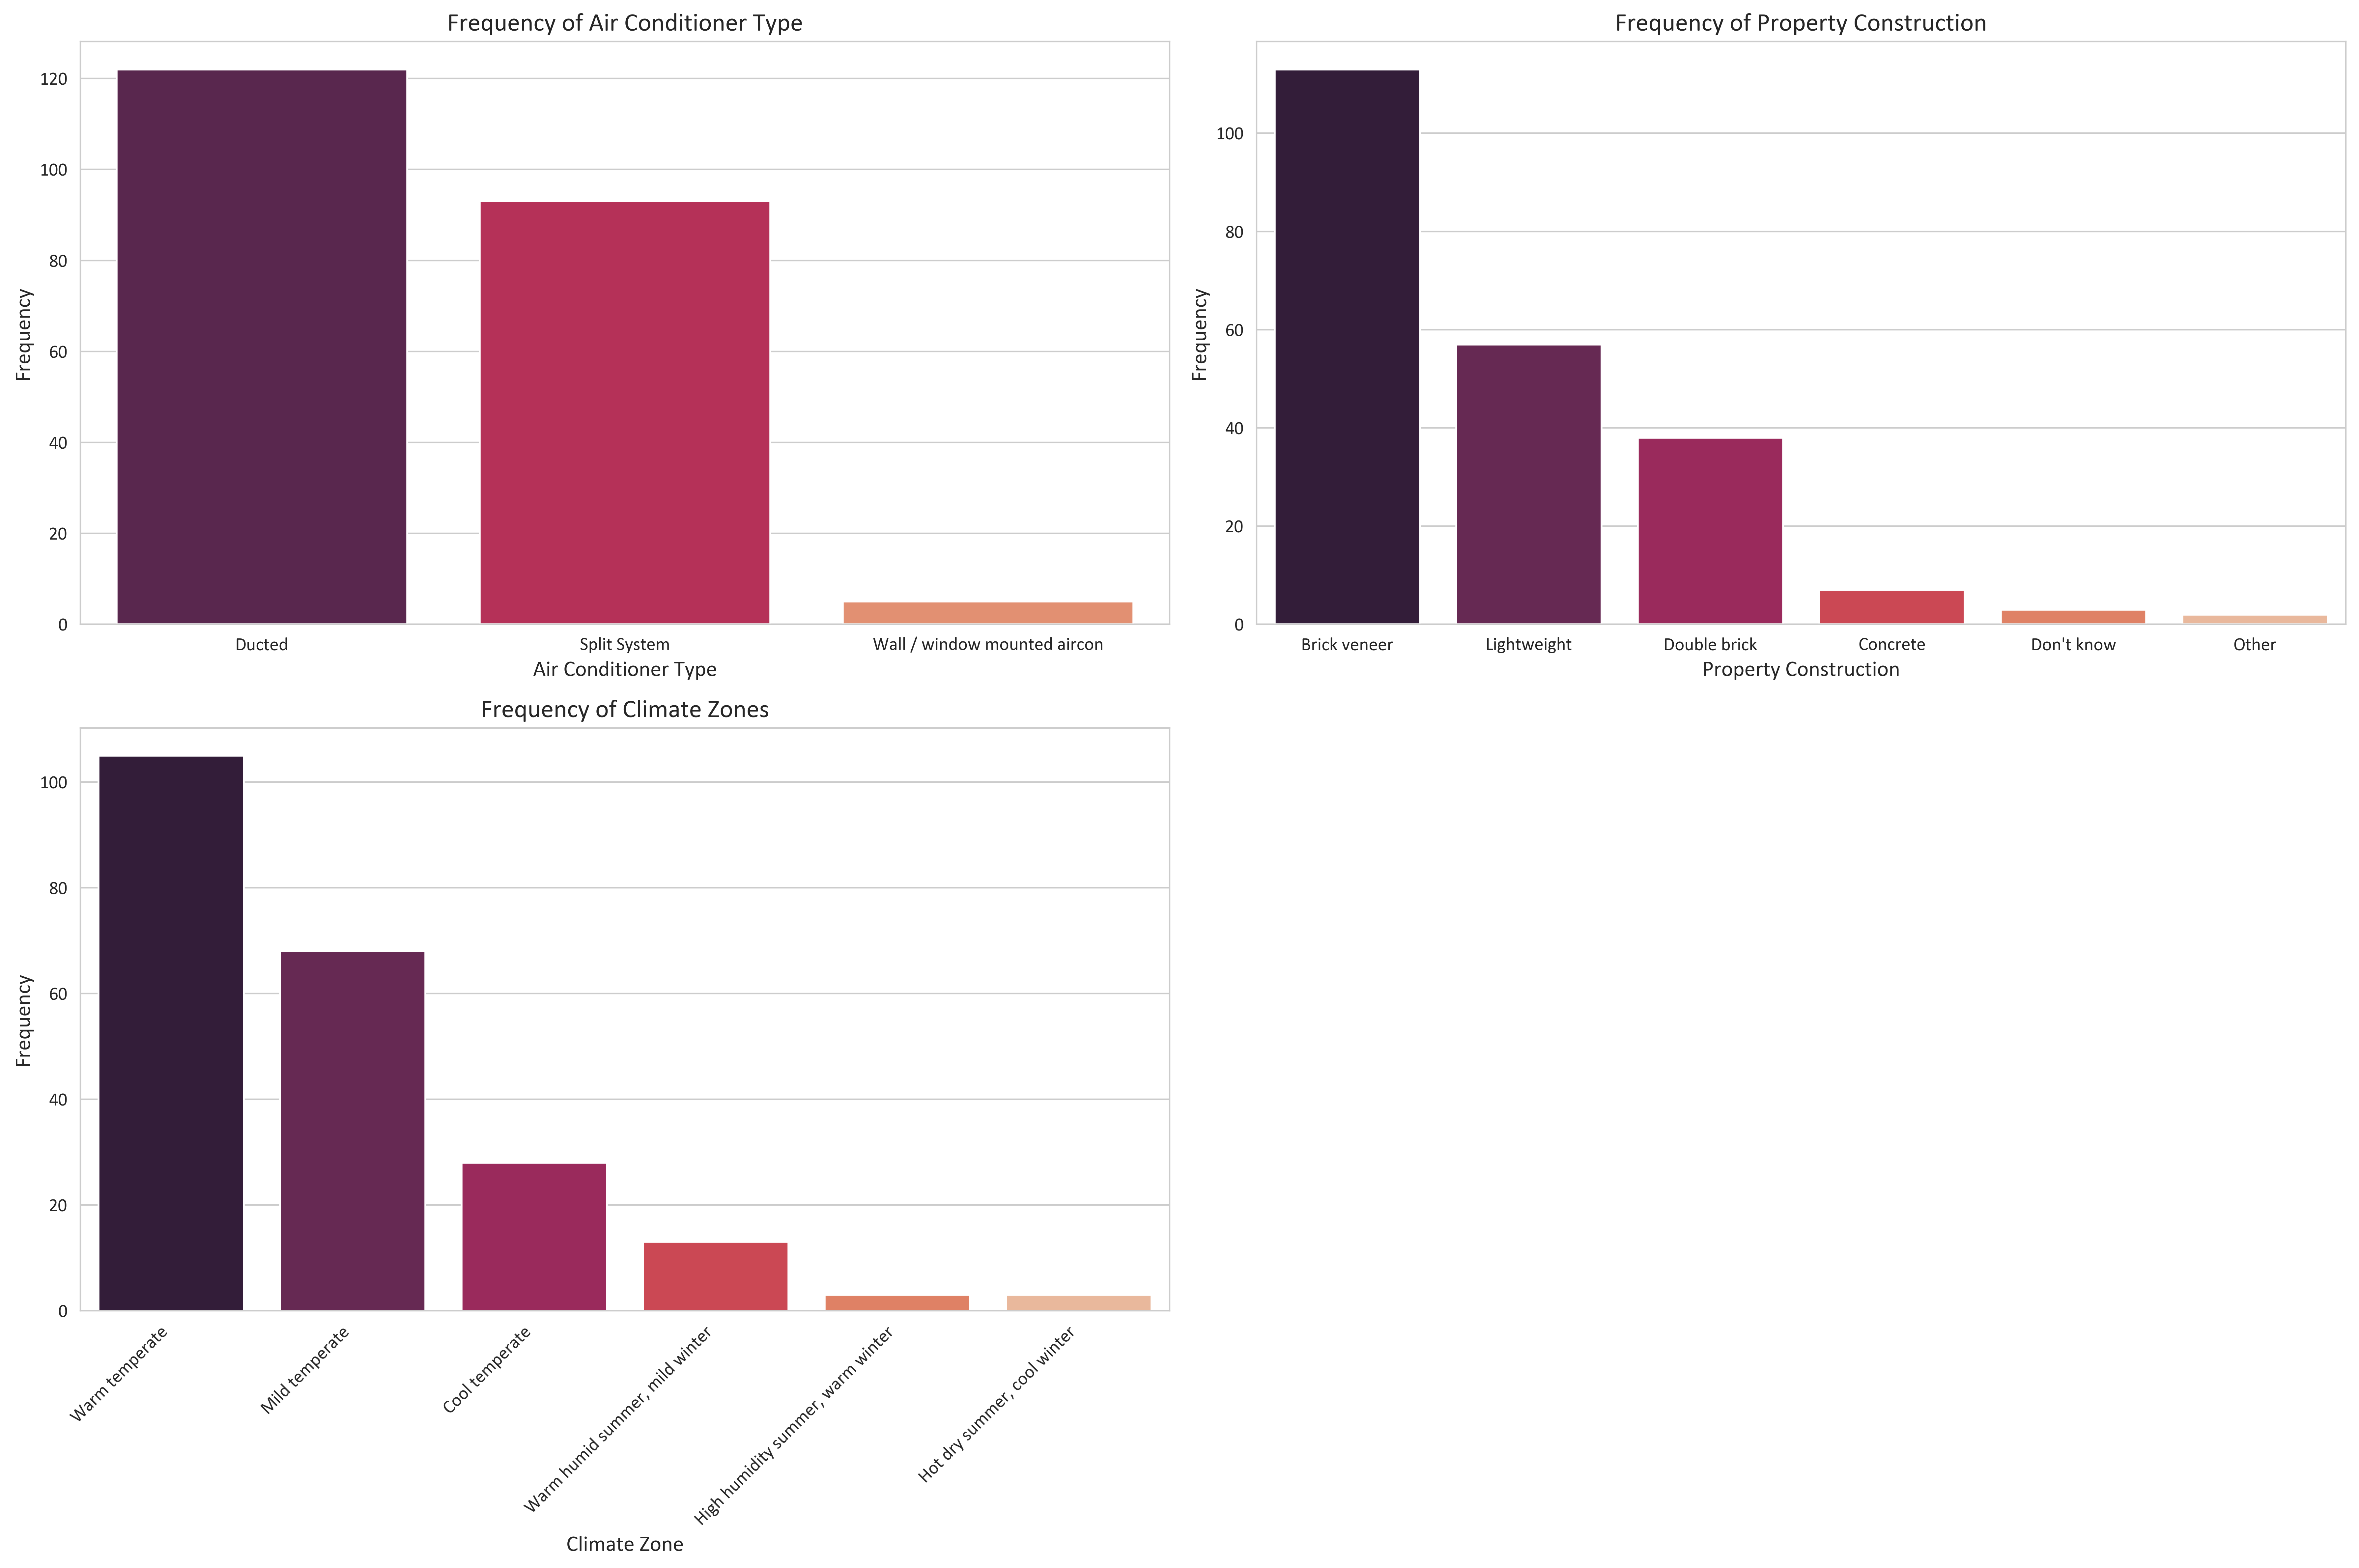

In [224]:
# create summary table with mean, median, and std of num_bedrooms and num_occupants
summary_table = filtered_survey[['num_bedrooms', 'num_occupants']].agg(['mean', 'median', 'std'])

# convert values to 2 decimal places
summary_table = summary_table.round(2)

# rename columns
summary_table.columns = ['Number of Bedrooms', 'Number of Occupants']

# Define categories for plotting
data_categories = {
    "Air Conditioner Type": filtered_survey['aircon_type_simplified'],
    "Property Construction": filtered_survey['property_construction'],
    "Climate Zone": filtered_survey['climate_zone'].map({
        1: 'High humidity summer, warm winter',
        2: 'Warm humid summer, mild winter',
        3: 'Hot dry summer, warm winter',
        4: 'Hot dry summer, cool winter',
        5: 'Warm temperate',
        6: 'Mild temperate',
        7: 'Cool temperate',
        8: 'Alpine'
    })
}

# Set style and font
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Calibri"

# Create subplots in stacked layout
fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi = 400, gridspec_kw={'height_ratios': [1, 1]})

for ax, (title, data) in zip(axes[0], list(data_categories.items())[:2]):
    sns.barplot(
        x=data.value_counts().index, y=data.value_counts().values, 
        hue=data.value_counts().index, legend=False, palette="rocket", ax=ax
    )
    ax.set_title(f"Frequency of {title}", fontsize=14)
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.tick_params(axis='x', rotation=30 if title == "Climate Zone" else 0)

sns.barplot(
    x=data_categories["Climate Zone"].value_counts().index, 
    y=data_categories["Climate Zone"].value_counts().values, 
    hue=data_categories["Climate Zone"].value_counts().index, 
    legend=False, palette="rocket", ax=axes[1, 0]
)
axes[1, 0].set_title("Frequency of Climate Zones", fontsize=14)
axes[1, 0].set_xlabel("Climate Zone", fontsize=12)
axes[1, 0].set_ylabel("Frequency", fontsize=12)
# set rotation anchor to the center of the x-axis labels
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# Create table for numerical summary
df_summary = summary_table

axes[1, 1].axis("off")
# convert summary_table to pandas df and drop index
summary_table = pd.DataFrame(summary_table)

# rename index as summary statistic
summary_table.index.name = 'Summary Statistic'

# remove index header
summary_table = summary_table.reset_index(drop=False)


plt.tight_layout()
plt.show()


# save figure as image
fig.savefig(os.path.join(output_directory, 'survey_data_frequencies.png'))

In [219]:
# potentiall need latex to put tables in overleaf? 

summary_table_gt = gt.GT(summary_table)
print(summary_table_gt.as_latex())


\begin{table}[!t]


\fontsize{12.0pt}{14.4pt}\selectfont

\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}lrr}
\toprule
Summary Statistic & Number of Bedrooms & Number of Occupants \\ 
\midrule\addlinespace[2.5pt]
mean & 3.73 & 3.32 \\
median & 4.0 & 3.0 \\
std & 0.78 & 1.28 \\
\bottomrule
\end{tabular*}

\end{table}

